In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

data = pd.read_parquet('scraped_data.parquet')

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)

def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def count_positive(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('positive', 0)

def count_negative(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('negative', 0)

def count_neutral(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('neutral', 0)

def calc_agreement(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus (everyone agrees).
    Lower value = High disagreement or mostly neutral news.
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    agreement = 1 - np.sqrt(1 - inner_val)
    
    return agreement

def compute_volatility(df):

    # MA 1
    model = ARIMA(df['log_return'], order=(0, 0, 1))
    model_fit = model.fit()    

    df['ln_vi_t'] = np.log(model_fit.resid**2)

    df['ln_vi_t_soxx'] = np.log((df['log_return']-df['soxx_ret'])**2)
    
    return df

def add_ts(metrics):
    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]

    stocks_data = yf.Tickers(stocks)
    hist = stocks_data.history(period='3y', interval="1d")
    
    data_subset = hist[['Close', 'Volume', 'Dividends']]
    prices_long = data_subset.stack(level=1).reset_index()
    prices_long.columns = ['date', 'label', 'price', 'volume', 'dividend']

    prices_long['dividend_dummy'] = np.where(prices_long['dividend'] > 0, 1, 0)
    
    prices_long = prices_long.sort_values(['label', 'date'])

    prices_long['log_return'] = prices_long.groupby('label')['price'].transform(
        lambda x: 100*np.log(x/x.shift(1))
    )
    
    prices_long['log_return_lag'] = prices_long.groupby('label')['log_return'].shift(1)
    prices_long['lag_neg'] = np.where(prices_long['log_return_lag']<0,1,0)

    prices_long['log_volume'] = np.log(prices_long['volume'])
    prices_long['log_volume_lag'] = prices_long.groupby('label')['log_volume'].shift(1)

    prices_long['date'] = prices_long['date'].dt.strftime('%Y-%m-%d')

    soxx = yf.Ticker("SOXX").history(period='5y')[['Close']]
    soxx['soxx_ret'] = 100*np.log(soxx['Close']/soxx['Close'].shift(1))
    soxx.index = pd.to_datetime(soxx.index.date).strftime('%Y-%m-%d')
    soxx = soxx[['soxx_ret']].reset_index().rename(columns={'index': 'date'})

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')
    combined_df = combined_df.merge(soxx, on='date', how='left')

    combined_df['bullishness_lag'] = combined_df.groupby('label')['bullishness_index'].shift(1)
    combined_df['agreement_lag'] = combined_df.groupby('label')['agreement_index'].shift(1)
    combined_df['article_count_lag'] = combined_df.groupby('label')['article_count'].shift(1)
    combined_df['n_positive_lag'] = combined_df.groupby('label')['n_positive'].shift(1)
    combined_df['n_neutral_lag'] = combined_df.groupby('label')['n_neutral'].shift(1)
    combined_df['n_negative_lag'] = combined_df.groupby('label')['n_negative'].shift(1)
    combined_df['soxx_ret_lag'] = combined_df.groupby('label')['soxx_ret'].shift(1)

    combined_df = combined_df.dropna()

    combined_df.sort_values('date',ascending=True,inplace=True)

    combined_df = combined_df.groupby('label', group_keys=False).apply(compute_volatility)

    return combined_df



/home/leonardo/Public/projects/T&M-assignment2/tam_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


### FINBERT
- We took the first paragrah as the scraped articles as it contains a summary of the article itself.
- Finbert gives probabilities to the article, whether it is positive/negative/neutral, and assign a sentiment according to the highest assigned probabilty.
- we took article which assigned sentiment is higher than 0.5
### Sentiment
- We replicate two indicators from a popular paper of Antweiler & Frank (2004).
    - Bullishness Index: Mood of the news. can be either above or below 0
    - Agreement Index: Measure consensus in articles. ranges from 0 to 1.
### Features Engineering
- log_returns = 100\*ln(pt/pt-1): we multiply by 100 for models stability
- log_volume = we took ln of the volume to stabilize the data 
- we create lagged variables for most each stock: bullishness_lag, agreement_lag, etc
### Volatility Computation (ln_vi_t)
- **Idiosyncratic Volatility**: the part of the stock's movement that cannot be explained by yesterday's price patterns.
- We use the same logic as in the paper to compute the daily volatilty. for each stock, we compute a MA(1) for the log_return, and we take the log of squared the residuals. In this way we clean for short term noise. the idea is that we are mimiking the *bid-ask bounce* of the paper. (they are using intraday data that we do not have)
- In this way we get the portion of a stock's price fluctuation that is unique to that specific company.


In [16]:
SENTIMENT_REF_COLUMN = 'fist_parag'

data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data[SENTIMENT_REF_COLUMN].apply(finbert_sentiment).apply(pd.Series)


In [17]:
# compute metrics i.e. market bullishness and agreement
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)

# filter for certain articles

TRESHOLD = 0.5
cond = (
    ((data['fb_positive']>TRESHOLD) & (data['sentiment']=='positive')) |
    ((data['fb_neutral']>TRESHOLD) & (data['sentiment']=='neutral')) |
    ((data['fb_negative']>TRESHOLD) & (data['sentiment']=='negative'))
)

metrics = data[cond].groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    agreement_index = calc_agreement,
    article_count = 'count',
    n_positive = count_positive,
    n_neutral = count_neutral,
    n_negative = count_negative

)

clean_data = add_ts(metrics)
clean_data.head(2)

/tmp/ipykernel_16891/3358559555.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)
[*********************100%***********************]  5 of 5 completed
/tmp/ipykernel_16891/333149177.py:121: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  prices_long = data_subset.stack(level=1).reset_index()
/home/leonardo/Public/projects/T&M-assignment2/tam_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the suppo

,date,label,price,volume,dividend,dividend_dummy,log_return,log_return_lag,lag_neg,log_volume,...,soxx_ret,bullishness_lag,agreement_lag,article_count_lag,n_positive_lag,n_neutral_lag,n_negative_lag,soxx_ret_lag,ln_vi_t,ln_vi_t_soxx
2264,2023-02-01,META,152.057816,55661000,0.0,0,2.747701,1.290434,0,17.834790,...,5.083132,-0.693147,0.133975,2.0,0.0,1.0,1.0,1.847603,1.877944,1.696392
2265,2023-02-02,META,187.460510,150475700,0.0,0,20.930740,2.747701,0,18.829312,...,2.290346,-1.098612,0.133975,4.0,0.0,2.0,2.0,5.083132,6.069477,5.850662


In [62]:
merged_data.groupby('label')['article_count'].sum()

label
AMD     2644.0
ASML     421.0
GOOG    3767.0
META    5166.0
NVDA    7368.0
Name: article_count, dtype: float64

In [48]:
clean_data

,date,label,price,volume,dividend,dividend_dummy,log_return,log_return_lag,lag_neg,log_volume,...,bullishness_lag,agreement_lag,article_count_lag,n_positive_lag,n_neutral_lag,n_negative_lag,soxx_ret_lag,ln_vi_t,ln_vi_t_soxx,agreement_group
2264,2023-02-01,META,152.057816,55661000,0.0,0,2.747701,1.290434,0,17.834790,...,-0.693147,0.133975,2.0,0.0,1.0,1.0,1.847603,1.877944,1.696392,2. Mixed/Low Agreement
2265,2023-02-02,META,187.460510,150475700,0.0,0,20.930740,2.747701,0,18.829312,...,-1.098612,0.133975,4.0,0.0,2.0,2.0,5.083132,6.069477,5.850662,2. Mixed/Low Agreement
2266,2023-02-03,META,185.236069,76809700,0.0,0,-1.193715,20.930740,0,18.156841,...,0.287682,0.004141,11.0,3.0,6.0,2.0,2.290346,-0.133644,-0.504813,2. Mixed/Low Agreement
2267,2023-02-06,META,184.769302,42483800,0.0,0,-0.252303,-1.193715,1,17.564633,...,0.000000,0.000000,2.0,0.0,2.0,0.0,-1.970644,-1.540772,0.651560,1. No Agreement/Single Article
2268,2023-02-07,META,190.290741,47080700,0.0,0,2.944509,-0.252303,1,17.667374,...,-0.916291,0.133975,6.0,1.0,1.0,4.0,-1.637413,2.018959,-3.363206,2. Mixed/Low Agreement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2026-01-15,GOOG,333.160004,16424900,0.0,0,-0.941048,-0.035674,1,16.614309,...,0.000000,0.000000,4.0,1.0,2.0,1.0,-0.420925,0.247095,1.857412,1. No Agreement/Single Article
3005,2026-01-15,META,620.799988,13076100,0.0,0,0.854148,-2.498105,1,16.386297,...,-1.386294,0.161860,11.0,1.0,3.0,7.0,-0.420925,-1.005429,-0.612952,2. Mixed/Low Agreement
1497,2026-01-15,ASML,1331.599976,2858400,0.0,0,5.232148,-0.508317,1,14.865773,...,1.098612,0.133975,4.0,2.0,2.0,0.0,-0.420925,3.378846,2.585046,2. Mixed/Low Agreement
743,2026-01-15,AMD,227.919998,55270200,0.0,0,1.913591,1.183182,0,17.827744,...,1.011601,0.070341,19.0,10.0,6.0,3.0,-0.420925,1.195217,-2.257685,2. Mixed/Low Agreement


In [18]:
import pandas as pd

test = pd.read_parquet('scraped_data_finbert.parquet')

In [19]:
test.shape

(24421, 12)

In [20]:
from pprint import pprint

idx = [7,1000,2000,3000,4000,5000,6000,7000,8000,9000,10010,11000,13000,15000,16000,17000,18000,22000,20500]

for idx,row in test.iloc[idx].iterrows():
    pprint(idx)
    pprint(f'company: {row['label']}')
    pprint(f'sentiment: {row['sentiment']}')
    pprint(row['fist_parag'])
    pprint('-------------------------------')


7
'company: AMD'
'sentiment: negative'
('Advanced Micro Devices (AMD) stock was down on Wednesday after the first '
 'benchmark for the upcoming Ryzen AI MAX+ 392 processor appeared on a '
 'benchmark test spotted by Wccftech. The latest benchmark test was '
 'impressive, with the Ryzen AI MAX+ 392 scoring 2,917 points on the '
 'single-core test and 18,071 points in the multi-core test.')
'-------------------------------'
1000
'company: AMD'
'sentiment: positive'
('Advanced Micro Devices (NASDAQ:AMD) stock has already navigated several '
 'headline-making developments in the early months of the Trump administration '
 '– events with meaningful implications for entire industries and individual '
 'companies alike. The latest announcement, however, sent AMD shares up ~7% '
 'this week.')
'-------------------------------'
2000
'company: AMD'
'sentiment: neutral'
('Notable companies reporting after the market close, with earnings consensus, '
 'include Alphabet (GOOG) (GOOGL), consensus $

# Volatility Analysis
Some volatility definitions:
    - VOLATILITY: measures how much and how quickly an asset's price changes over time, indicating risk and uncertainty.
    - IDIOSYNCRATIC VOLATILITY: the part of the stock's movement that cannot be explained by yesterday's price patterns.

- What we are looking at: a more pure version of the volatily, something that cannot be explained by yesterday price movements. the MA methodology follows another paper from Andersen et al. (2001) - which says that for sentiment analysis we first need to remove the "*mechanical*" market movements (like the bid-ask bounce (see below) or simple mean reversion). Steps:
    - MA(1): We assume that todays return can be predicted by yesterday returns, the residuals are the shock/surprise movement
    - Squared: we squared the residuals as we care about the magnitude and not the direction
    - Log: to normalize the results -> standard practice in finance
- WHY NOT THE STD? 
    - if we used a window std we would contaminate the standard deviation with previous days movements
    - Residual Volatility is point-in-time; it shows exactly how much the market reacted that specific day. -> in fact by using t-1 Business Insider article we predict well the movement

### Variables (SEE next MARKDOWN for deeper description of the variables - in this case we copy the paper regression)
- we attempted to **broadly** replicate paper's finding and regression.
- we use the following variables to predict the volatility:
    - agreement_t-1
    - article_count_t-1
    - lag_neg (bool): at t-1 we have negative returns
    - log_volume_t-1: volume traded in t-1, in the paper they find that it is important for volatility. Howoever they use log_volume_t. 
- WHY LAGGED VARIABLES: 
    - To test if todays data can predict upcoming movements
    - In stock markets variables moves together and one may cause the other. Which caused what??? We used volatility as time t-1 to avoid using macro-econometrics modelling and make complex assumptions.
    - Simultaneity Bias: Volume and Volatility are strictly correlated.
    - We found that that lagged agreement is significant: meaning that people have to digest the information.
    - Lagged variable works as early-warning of what is going to happen.


## Results
- Agreement Index: The positive coefficient (0.6794) indicates that high consensus among journalists leads to higher volatility. In professional news, agreement signals a "coordinated information shock" that triggers massive trading. 
- Article Count: More articles yesterday = higher volatility today. This supports the "Attention Theory"—as news coverage intensifies, more investors are drawn to the stock, increasing fluctuations.
- Negative return (bool): If the stock went down yesterday, investors are more "jittery" today, leading to higher volatility than if the stock had gone up. -> "Negative Return" controls. They included previous returns to account for the Leverage Effect (the fact that volatility usually rises after a price drop).
- Volume (AKA TRADING ACTIVITY): As in the paper it is a relevant control and provide additional informations

# Paper Differences
- In the paper they get data from yahoo finance and 'raging Bull' boards. these are Retail Data(unfiltered, short, and anonymus). Business Insider are professional journalists.

Labelling Difference:
- Antweiler & Frank (2004): Used Naive Bayes and SVM. These are "Bag-of-Words" models. "Not Good" can be interpreted as positive it sees only "Good".
- Us: Transformers are more accurate

Findings Differences:
- Antweiler & Frank (2004): When retail traders argue (DISAGREEMENT), they trade more against each other, creating "noise.": High disagreement -> Higher Volume.
- Us: When professional journalists agree, they create a unified "Information Shock" that moves the whole market. High agreement → Higher Volatility.

In [21]:
# volatility as in the paper
X_returns = clean_data[['agreement_lag',
                        'article_count_lag',
                        'lag_neg',
                        'log_volume_lag'
                        ]]
X_returns = sm.add_constant(X_returns)
y_returns = clean_data['ln_vi_t']

model_returns = sm.OLS(y_returns, X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     10.78
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           1.19e-08
Time:                        18:55:02   Log-Likelihood:                -5006.0
No. Observations:                2197   AIC:                         1.002e+04
Df Residuals:                    2192   BIC:                         1.005e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.8067      0.65

/tmp/ipykernel_16891/2464966745.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agreement_group',


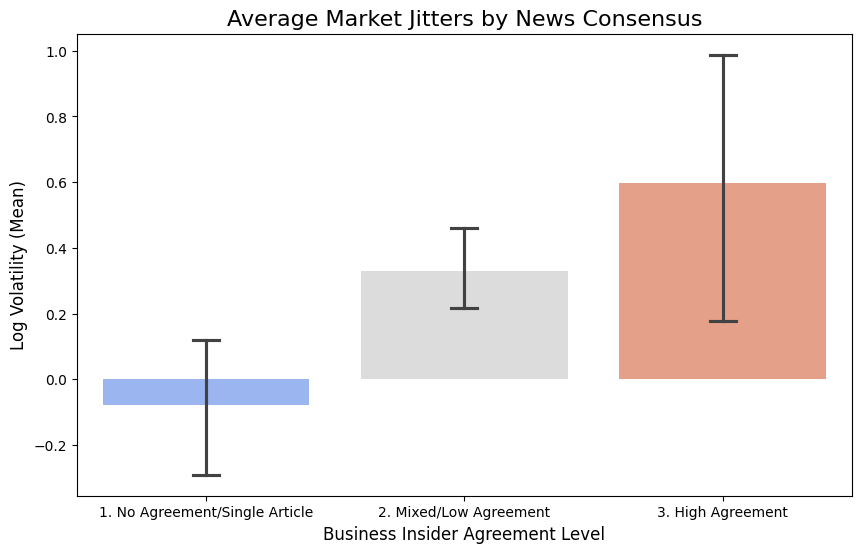

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create 3 simple categories manually to avoid the qcut error
def categorize_agreement(x):
    if x == 0: return "1. No Agreement/Single Article"
    if x < 0.5: return "2. Mixed/Low Agreement"
    return "3. High Agreement"

clean_data['agreement_group'] = clean_data['agreement_lag'].apply(categorize_agreement)

plt.figure(figsize=(10, 6))
sns.barplot(x='agreement_group',
            y='ln_vi_t',
            data=clean_data,
            palette='coolwarm',
            capsize=.1,
            order=[
    "1. No Agreement/Single Article", 
    "2. Mixed/Low Agreement", 
    "3. High Agreement"
        ])

plt.title('Average Market Jitters by News Consensus', fontsize=16)
plt.xlabel('Business Insider Agreement Level', fontsize=12)
plt.ylabel('Log Volatility (Mean)', fontsize=12)
plt.show()

In [23]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

anomalies = stock_anomaly.get_anomalies()
anomalies['date'] = anomalies['date'].dt.strftime('%Y-%m-%d')
anomalies['high_volatility'] = int(1)

[*********************100%***********************]  5 of 5 completed


In [24]:
clean_data.shape

(2197, 28)

In [25]:

merged_data = clean_data.merge(anomalies[['date','stock','high_volatility']],
                              how='left',
                              left_on = ['date', 'label'],
                              right_on = ['date','stock'])

In [26]:
merged_data.drop(columns='stock',inplace=True)
merged_data['high_volatility'] = merged_data['high_volatility'].fillna(0)
merged_data['high_vol_tmrrw'] = merged_data['high_volatility'].shift(-1)



In [27]:
# merged_data.dropna(inplace=True)

In [28]:
# weighting
n_total = len(merged_data)
n_events = merged_data['high_volatility'].sum()
n_normal = n_total - n_events

# Weight for the rare event (Class 1) and normal day (Class 0)
weight_event = n_total / (2 * n_events)
weight_normal = n_total / (2 * n_normal)

weights = merged_data['high_volatility'].apply(lambda x: weight_event if x == 1 else weight_normal)
n_events,n_normal

(np.float64(53.0), np.float64(2144.0))

# Weighting and Final Regression

- Weights are inversly proportional to their frequency. Wrong prediction are costly.
- The "2" in the denominator: This ensures that the sum of weights for Class 0 equals the sum of weights for Class 1. This effectively simulates a dataset where you have an equal number of "shocks" and "quiet days," allowing the coefficients to reflect the true predictive power of the news.

### Variables used:
- bullishness: Measure the direction of the news aka levarage effect. Bad news normally drive volatility,
- agreement: This tests the "Difference of Opinion" Theory. It asks: "Does the market move because everyone is reacting to the same signal"
- article count: Attention induced volatility effect, because everyone is talking about it then it produces volatility
- Controls:
    - volume: high volume yesterda -> high volume today. We need this to take into account the effect of the news(sentiment) taking to consideration what is happening now.
    - lag_neg: if yesterday negative, today they are more likely to be volatile. so we do no induce volatility from yesteraday negative movement 

### Interpretation
- Bullishness index (significant): There is a strong negative relationship between news sentiment and volatility spikes. -> As Business Insider news becomes more bearish (lower bullishness), the probability of a massive market shock tomorrow increases significantly. This confirms the "Panic Effect": bad news travels with high volatility.
- Agreement Index (significant): Disagreement (low agreement) is a primary trigger for extreme volatility. When journalists are conflicted or reporting mixed signals, it reflects market uncertainty. Once that uncertainty is resolved (usually the next day), the price "snaps," creating the high-volatility

### Differences with the paper and previous shocks
- OLS results: Agreement drives daily volatily. GLM results: Disagreement drives extreme shocks. The latter is aligned with the Paper, i.e. difference in opinion leads to market turmoil

In [29]:
import statsmodels.api as sm

pred = ['bullishness_lag',
        'agreement_lag',
        'article_count_lag',
        'lag_neg',
        'log_volume_lag']

predictors = sm.add_constant(
    merged_data[pred]
)

weighted_model = sm.GLM(merged_data['high_volatility'], predictors,
                        family=sm.families.Binomial(), freq_weights=weights).fit()

print(weighted_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        high_volatility   No. Observations:                 2197
Model:                            GLM   Df Residuals:                     2191
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1508.8
Date:                Fri, 30 Jan 2026   Deviance:                       3017.7
Time:                        18:55:02   Pearson chi2:                 2.20e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01266
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0345      0.52

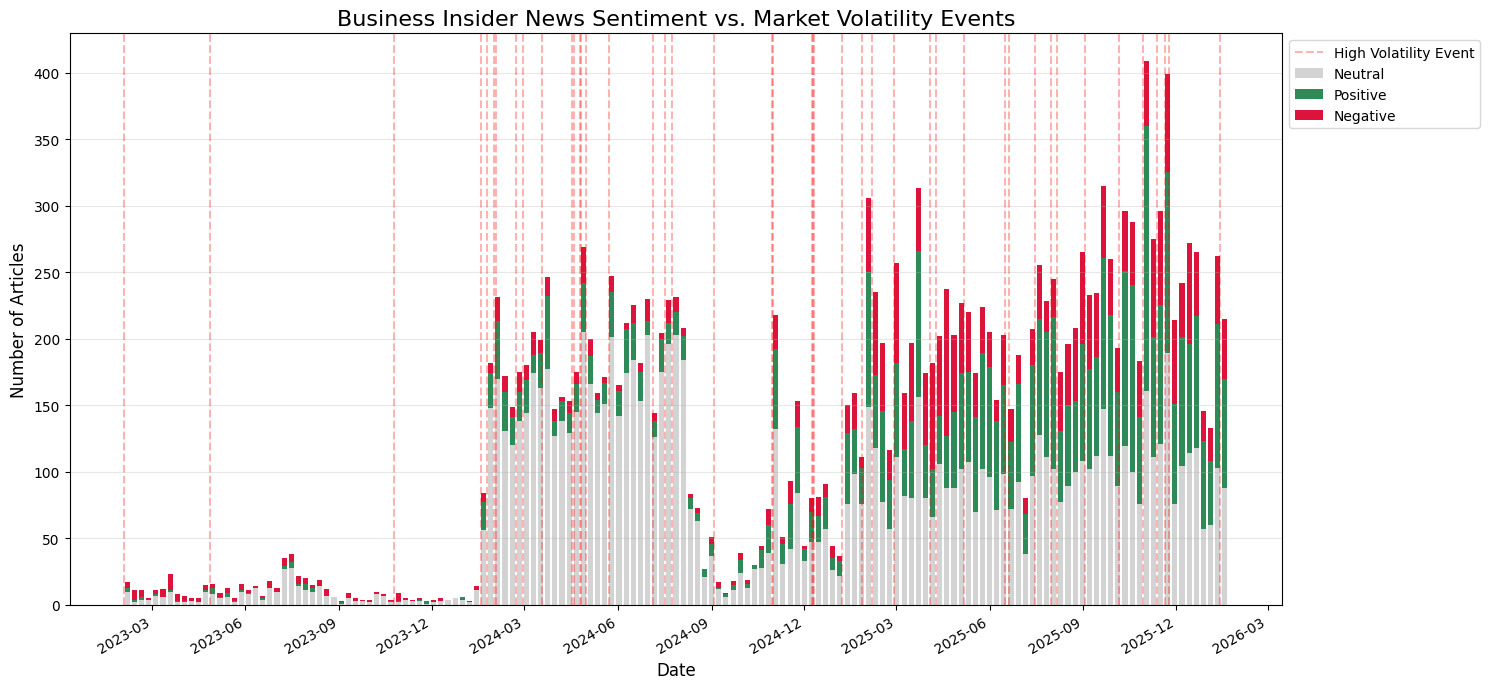

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Prepare the Data
# Ensure date is in datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Aggregate by Date to combine different stocks into a single "Market View"
# We sum the sentiment counts and take the max of high_volatility (if any stock spiked, it's an event)
daily_agg = merged_data.groupby('date').agg({
    'n_positive': 'sum',
    'n_negative': 'sum',
    'n_neutral': 'sum',
    'high_volatility': 'max'
}).sort_index()

# Optional: To make bars readable, you can group by Week ('W') or Month ('M')
# Change 'D' to 'W' if you have too many dates
plot_data = daily_agg.resample('W').sum() 

# 2. Identify Event Dates for the red lines
# We go back to the daily data to find the exact days of the 100 events
event_dates = daily_agg[daily_agg['high_volatility'] == 1].index

# 3. Create the Plot
plt.figure(figsize=(15, 7))

# Plot Stacked Bars
plt.bar(plot_data.index, plot_data['n_neutral'], label='Neutral', color='lightgrey', width=5)
plt.bar(plot_data.index, plot_data['n_positive'], bottom=plot_data['n_neutral'], 
        label='Positive', color='seagreen', width=5)
plt.bar(plot_data.index, plot_data['n_negative'], 
        bottom=plot_data['n_neutral'] + plot_data['n_positive'], 
        label='Negative', color='crimson', width=5)

# Add Vertical Red Lines for High Volatility Events
for i, event_date in enumerate(event_dates):
    plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.3, 
                label='High Volatility Event' if i == 0 else "")

# Formatting
plt.title('Business Insider News Sentiment vs. Market Volatility Events', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.3)

# Improve Date Formatting on X-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()

plt.tight_layout()

plt.show()

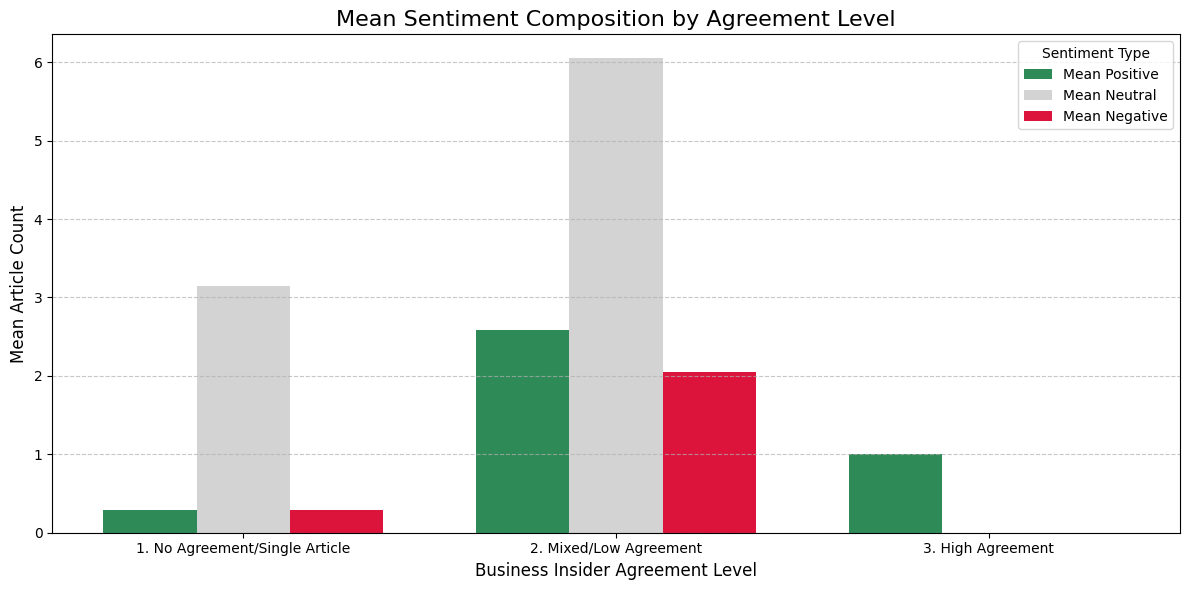

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare the data: Calculate the mean counts per agreement group
sentiment_means = merged_data[merged_data['high_volatility']==1].groupby('agreement_group')[['n_positive_lag', 'n_neutral_lag', 'n_negative_lag']].mean()

# 2. Ensure the order matches your previous charts
order_list = [
    "1. No Agreement/Single Article", 
    "2. Mixed/Low Agreement", 
    "3. High Agreement"
]
sentiment_means = sentiment_means.reindex(order_list)
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare data (Assuming sentiment_means and order_list are defined)
# Re-index to ensure the specific order
sentiment_means = sentiment_means.reindex(order_list)

x = np.arange(len(sentiment_means.index))  # The label locations
width = 0.25  # The width of the individual bars

fig, ax = plt.subplots(figsize=(12, 6))

# 2. Plotting each category with an offset
# We center the 'Neutral' bar and shift Positive to the left and Negative to the right
rects1 = ax.bar(x - width, sentiment_means['n_positive_lag'], width, label='Mean Positive', color='seagreen')
rects2 = ax.bar(x,         sentiment_means['n_neutral_lag'],  width, label='Mean Neutral',  color='lightgrey')
rects3 = ax.bar(x + width, sentiment_means['n_negative_lag'], width, label='Mean Negative', color='crimson')

# 3. Formatting
ax.set_title('Mean Sentiment Composition by Agreement Level', fontsize=16)
ax.set_xlabel('Business Insider Agreement Level', fontsize=12)
ax.set_ylabel('Mean Article Count', fontsize=12)

# Set the x-ticks to be in the middle of the group
ax.set_xticks(x)
ax.set_xticklabels(sentiment_means.index)
ax.legend(title='Sentiment Type')

# Optional: Add gridlines for easier reading of the counts
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [32]:
sentiment_means = merged_data[merged_data['high_volatility']==1].groupby('agreement_group')[['n_positive_lag', 'n_neutral_lag', 'n_negative_lag']].mean()
sentiment_means

,n_positive_lag,n_neutral_lag,n_negative_lag
agreement_group,,,
1. No Agreement/Single Article,0.285714,3.142857,0.285714
2. Mixed/Low Agreement,2.578947,6.052632,2.052632
3. High Agreement,1.000000,0.000000,0.000000


In [33]:
merged_data['bullishness_lag'].min()

np.float64(-1.9459101490553135)

/tmp/ipykernel_16891/2780943521.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = merged_data.groupby('sentiment_type')['high_volatility'].mean() * 100
/tmp/ipykernel_16891/2780943521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')


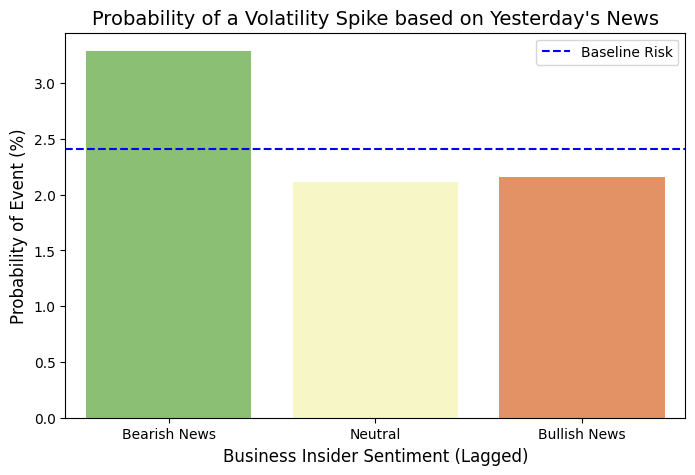

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create Bullishness Buckets (Negative vs Positive)
merged_data['sentiment_type'] = pd.cut(merged_data['bullishness_lag'], 
                                       bins=[-np.inf, -0.1, 0.1, np.inf], 
                                       labels=['Bearish News', 'Neutral', 'Bullish News'])

# 2. Calculate the Probability (Mean of the binary high_volatility flag)
# Multiply by 100 to show as a percentage
prob_df = merged_data.groupby('sentiment_type')['high_volatility'].mean() * 100

# 3. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')

plt.title('Probability of a Volatility Spike based on Yesterday\'s News', fontsize=14)
plt.ylabel('Probability of Event (%)', fontsize=12)
plt.xlabel('Business Insider Sentiment (Lagged)', fontsize=12)
plt.axhline(merged_data['high_volatility'].mean()*100, color='blue', linestyle='--', label='Baseline Risk')
plt.legend()
plt.show()

In [35]:
merged_data.columns

Index(['date', 'label', 'price', 'volume', 'dividend', 'dividend_dummy',
       'log_return', 'log_return_lag', 'lag_neg', 'log_volume',
       'log_volume_lag', 'bullishness_index', 'agreement_index',
       'article_count', 'n_positive', 'n_neutral', 'n_negative', 'soxx_ret',
       'bullishness_lag', 'agreement_lag', 'article_count_lag',
       'n_positive_lag', 'n_neutral_lag', 'n_negative_lag', 'soxx_ret_lag',
       'ln_vi_t', 'ln_vi_t_soxx', 'agreement_group', 'high_volatility',
       'high_vol_tmrrw', 'sentiment_type'],
      dtype='object')

/tmp/ipykernel_16891/1721586651.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')


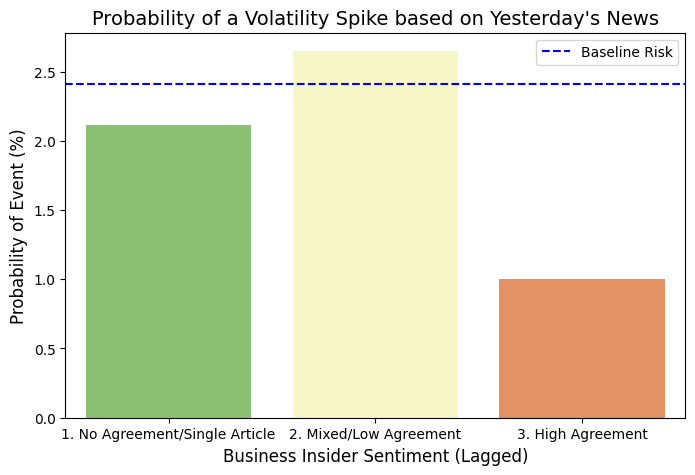

In [36]:
# 1. Create Bullishness Buckets (Negative vs Positive)
merged_data['sentiment_type'] = pd.cut(merged_data['bullishness_lag'], 
                                       bins=[-np.inf, -0.1, 0.1, np.inf], 
                                       labels=['Bearish News', 'Neutral', 'Bullish News'])

# 2. Calculate the Probability (Mean of the binary high_volatility flag)
# Multiply by 100 to show as a percentage
prob_df = merged_data.groupby('agreement_group')['high_volatility'].mean() * 100

# 3. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')

plt.title('Probability of a Volatility Spike based on Yesterday\'s News', fontsize=14)
plt.ylabel('Probability of Event (%)', fontsize=12)
plt.xlabel('Business Insider Sentiment (Lagged)', fontsize=12)
plt.axhline(merged_data['high_volatility'].mean()*100, color='blue', linestyle='--', label='Baseline Risk')
plt.legend()
plt.show()

In [37]:
# Filter for 'Normal Days' only
normal_days_df = merged_data[merged_data['high_volatility'] == 0]

# Run the OLS regression on this sub-sample
X_normal = sm.add_constant(normal_days_df[
    ['bullishness_lag',
    'agreement_lag',
    'article_count_lag',
    'lag_neg',
    'log_volume_lag']])
y_normal = normal_days_df['ln_vi_t']

model_normal = sm.OLS(y_normal, X_normal).fit()
print(model_normal.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     9.503
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           5.61e-09
Time:                        18:55:03   Log-Likelihood:                -4829.4
No. Observations:                2144   AIC:                             9671.
Df Residuals:                    2138   BIC:                             9705.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.0594      0.65

In [38]:
# Filter for 'Normal Days' only
normal_days_df = merged_data[merged_data['high_volatility'] == 1]

# Run the OLS regression on this sub-sample
X_normal = sm.add_constant(normal_days_df[
    ['bullishness_lag',
    'agreement_lag',
    'article_count_lag',
    'lag_neg',
    'log_volume_lag']])
y_normal = normal_days_df['ln_vi_t']

model_normal = sm.OLS(y_normal, X_normal).fit()
print(model_normal.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.893
Date:                Fri, 30 Jan 2026   Prob (F-statistic):             0.0234
Time:                        18:55:03   Log-Likelihood:                -64.887
No. Observations:                  53   AIC:                             141.8
Df Residuals:                      47   BIC:                             153.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4624      1.42

In [2]:
anomalies = StockAnomaly(start='2022-12-15',end='2025-01-15')
anomalies.calculate(window=20,price_z=2,volume_z=2)


[*********************100%***********************]  5 of 5 completed


True

In [1]:
from StockAnomaly import StockAnomaly

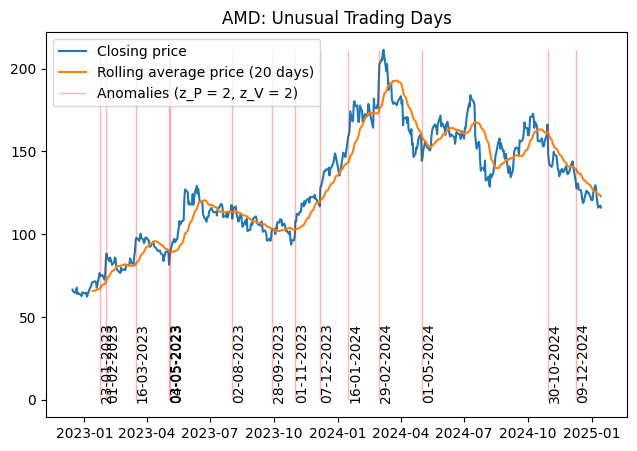

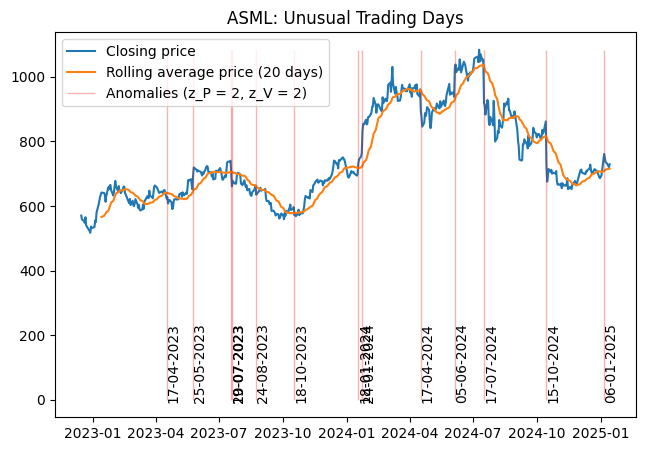

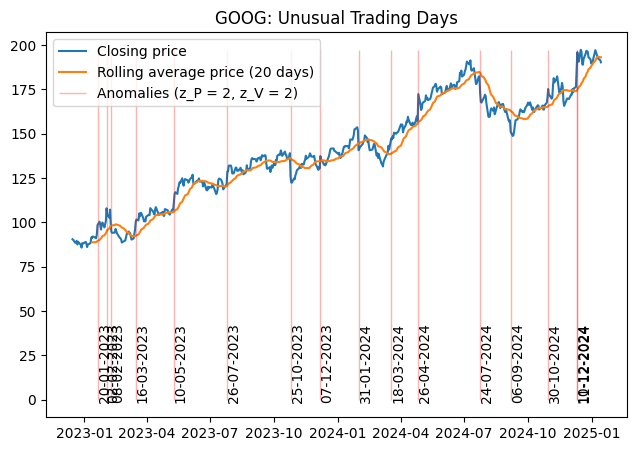

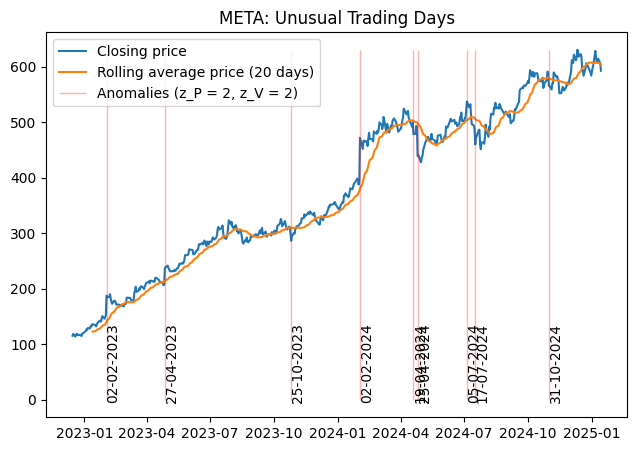

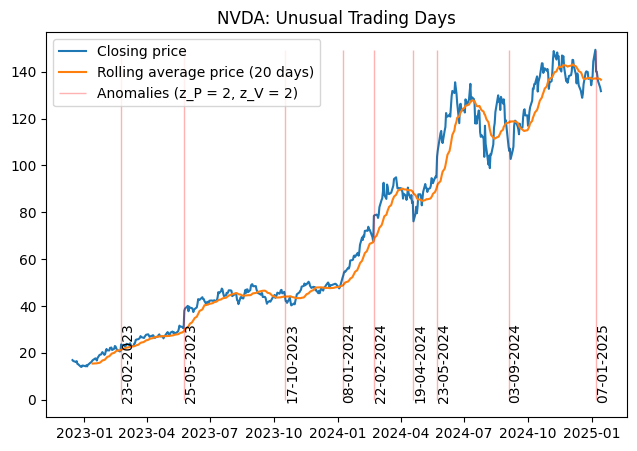

In [9]:
for i in anomalies.stocks:
    anomalies.display_anomalies(i,(7.5,5))

In [1]:
import pandas as pd

In [8]:
df = pd.read_parquet('scraped_data_finbert.parquet')

df[['label','fist_parag','sentiment']].iloc[5700]

label                                                      GOOG
fist_parag    Roth Capital lowered the firm’s price target o...
sentiment                                              negative
Name: 5700, dtype: object